In [1]:
from tensorflow.keras.models import load_model


model = load_model('model_weights_resnet-1.h5',compile=False)

In [2]:
print(model.input_shape)

(None, 256, 256, 3)


In [3]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


1/1 [==============================] - 1s 1s/step
Ground Truth Mask Area: 44272 pixels
Predicted Mask Area after Post-Processing: 45401 pixels
Combined Mask Area: 45401 pixels
IoU Score: 0.9455642099325248
Percentage Error in area: 2.55%


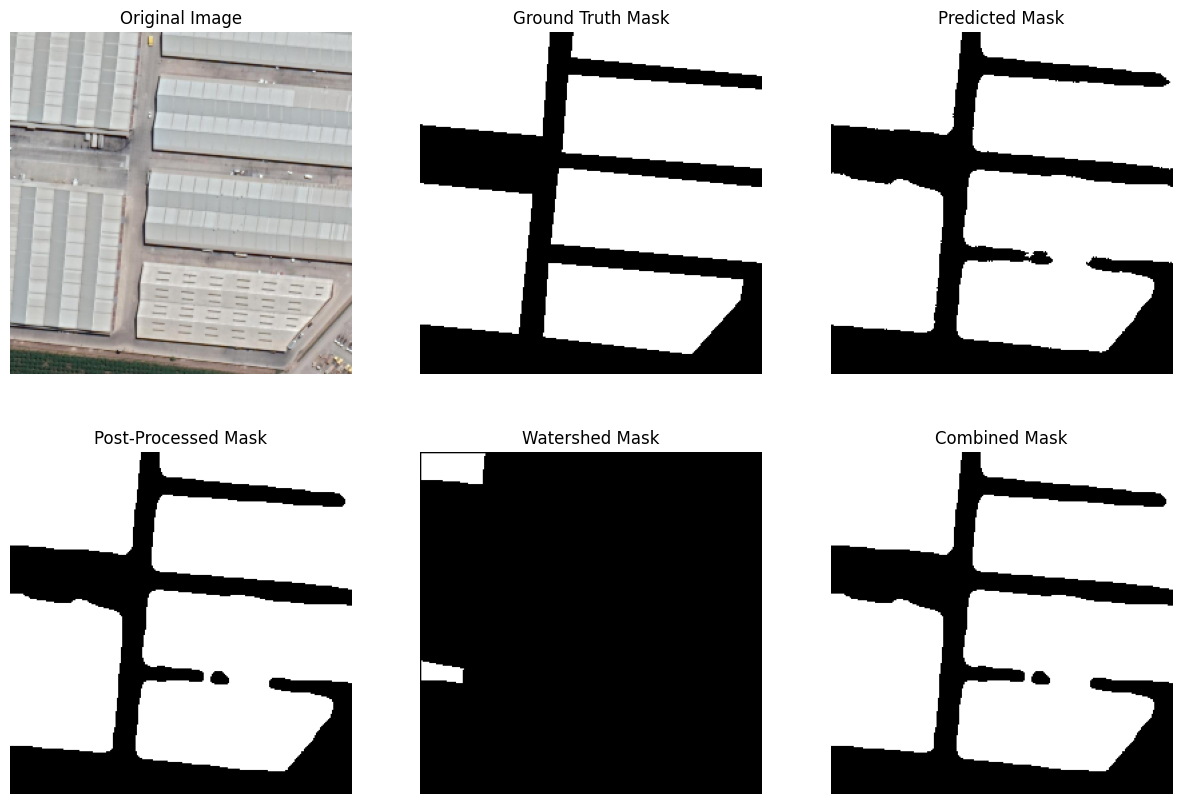

In [4]:


def preprocess_image(image_path, target_size):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    if img_array.shape[-1] == 4: 
        img_array = img_array[..., :3]
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0) 
    return img_array

def load_and_preprocess_mask(mask_path, target_size):
    mask = Image.open(mask_path)
    mask = mask.resize(target_size)
    mask_array = np.array(mask)
    if mask_array.ndim == 3 and mask_array.shape[-1] == 4:
        mask_array = mask_array[..., 0]  
    mask_array = mask_array > 0 
    return mask_array.astype(np.uint8)

def calculate_iou(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    union = np.logical_or(predicted_mask, ground_truth_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def post_process_mask(mask):
    kernel = np.ones((5, 5), np.uint8) 
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   
    mask = cv2.GaussianBlur(mask, (5, 5), 0)
    return mask

def watershed_algorithm(image, binary_mask):
    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    sure_bg = cv2.dilate(binary_mask, np.ones((3, 3), np.uint8), iterations=3)
    sure_bg = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[sure_bg == 255] = 0
    markers = cv2.watershed(image, markers)
    watershed_mask = (markers > 1).astype(np.uint8)
    return watershed_mask

def calculate_area(mask):
    return np.sum(mask)

# Load your trained model
# model = ... # Load your trained model here

img_path = "C:\\Users\\Lenovo\\Desktop\\postprocess -model\\dataset\\source\\DL52_4348_0_3.tif"
target_size = (256, 256)
preprocessed_image = preprocess_image(img_path, target_size)

predictions = model.predict(preprocessed_image)
predictions_binary = (predictions > 0.45).astype(np.uint8)

original_image_path = "C:\\Users\\Lenovo\\Desktop\\postprocess -model\\dataset\\source\\DL52_4348_0_3.tif"
original_image = cv2.imread(original_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) 
original_image_resized = cv2.resize(original_image, (256, 256))

ground_truth_mask_path = "C:\\Users\\Lenovo\\Desktop\\postprocess -model\\dataset\\labels\\DL52_4348_0_3.tif"
ground_truth_mask = load_and_preprocess_mask(ground_truth_mask_path, target_size)

binary_mask = predictions_binary[0]
post_processed_mask = post_process_mask(binary_mask)

# Apply the watershed algorithm to the original image and the post-processed mask
watershed_mask = watershed_algorithm(original_image_resized, post_processed_mask)

# Combine the post-processed mask and the watershed mask
combined_mask = np.logical_or(post_processed_mask, watershed_mask).astype(np.uint8)
# Calculate the area of the ground truth mask
ground_truth_area = calculate_area(ground_truth_mask)
print(f"Ground Truth Mask Area: {ground_truth_area} pixels")

# Calculate the area of t
post_processed_mask_area = calculate_area(post_processed_mask)
print(f"Predicted Mask Area after Post-Processing: {post_processed_mask_area} pixels")

# Calculate the area of the combined mask
combined_mask_area = calculate_area(combined_mask)
print(f"Combined Mask Area: {combined_mask_area} pixels")

# Calculate IoU score
iou_score = calculate_iou(combined_mask, ground_truth_mask)
print(f"IoU Score: {iou_score}")
if post_processed_mask_area>ground_truth_area:
    percentage_error = ((post_processed_mask_area - ground_truth_area) / ground_truth_area) * 100
elif ground_truth_area>post_processed_mask_area:
    percentage_error = ((ground_truth_area - post_processed_mask_area) / post_processed_mask_area) * 100

print(f"Percentage Error in area: {percentage_error:.2f}%")

# Visualize the original image, ground truth mask, predicted mask, post-processed mask, and combined mask
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(original_image_resized)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(ground_truth_mask, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Predicted Mask')
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Post-Processed Mask')
plt.imshow(post_processed_mask, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Watershed Mask')
plt.imshow(watershed_mask, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title('Combined Mask')
plt.imshow(combined_mask, cmap='gray')
plt.axis('off')

plt.show()


